# Seasonal Decomposition
Seasonal decomposition is the breakdown of time series data into their individual components, which usually consist of:
- Seasonality
- Irregularities
- Trends
- Cycles
- Random Error

The goal of the chapter is to understand the movement of the car sales without including economic data (this will be performed further).

#### Car Sales Data
The car sales dataset will be seasoanlly decomposed for:
- total_cars_sold
- new_cars_sold
- used_cars_sold
- total_value_cars_sold
- new_value_cars_sold
- used_cars_sold

#### Electric Vehicle Registration
- Plug in vehicles
- Electric vehicles
- Total electric vehicles

#### Import Packages

In [1]:
# import basic packages
import pandas as pd # for time series
import matplotlib.pyplot as plt # for plotting
import numpy as np # for mathematical functions

In [2]:
# seasonal decomposition packages
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# gridspec
import matplotlib.gridspec as gridspec

In [4]:
# evaluation techniques
from sklearn.metrics import mean_absolute_error

#### Import Data
Looking at the car sales dataset to download data

In [5]:
car_sales = pd.read_csv('/Users/ben_nicholson/Visual_Code_Projects/Personal_Projects/Maryland Automotive Industry/preprocessed_datasets/combined_data/car_sales.csv')
car_sales

,date,total_cars_sold,new_cars_sold,used_cars_sold,total_value_cars_sold,new_value_cars_sold,used_value_cars_sold,electric,plug-in_hybrid,total_electric_sales
0,2002-01-01,81033,31106,49927,1141497749,755015820,386481929,NaN,NaN,NaN
1,2002-02-01,78502,27520,50982,1025807465,664454223,361353242,NaN,NaN,NaN
2,2002-03-01,93019,34225,58794,1225051631,805666244,419385387,NaN,NaN,NaN
3,2002-04-01,96269,36452,59817,1279429447,846368297,433061150,NaN,NaN,NaN
4,2002-05-01,97936,37359,60577,1297575194,855005784,442569410,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
259,2023-08-01,78601,25876,52725,2131035952,1222581892,908454060,55728.0,25360.0,81088.0
260,2023-09-01,69278,23892,45386,1879114283,1134437699,744676584,58157.0,26022.0,84179.0
261,2023-10-01,69248,23775,45473,1863262680,1122680147,740582533,60136.0,26951.0,87087.0
262,2023-11-01,64980,22720,42260,1756655669,1062465105,694190564,61557.0,27423.0,88980.0


#### Import Functions

##### Plotting Data
- Plot single dataframe
- Plot multiple series with multiple x values
- Plot multiple series with one x value
- Histogram
- Plot Confidence Intervals

In [6]:
# create a function for line time series
def line_series(x,y,title,xlabel,ylabel,grid=False):
    plt.figure(figsize=(12,8))
    plt.plot(x,y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(grid)
    plt.show()

In [7]:
# create a function that plots multiple lines
def plot_multiple_series_multiple_xvalues(xvalues,yvalues,labels,title,xlabel,ylabel,alpha=None):
    plt.figure(figsize=(14,8))
    for i in range(len(labels)):
        plt.plot(xvalues[i], yvalues[i], label=labels[i],alpha=alpha[i])
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [8]:
from cycler import cycler
def plot_multiple_series_one_xvalues(xvalues, yvalues, labels, title, xlabel, ylabel, alpha=None):
    plt.figure(figsize=(14, 8))

    for i in range(len(labels)):
        plt.plot(xvalues, yvalues[i], label=labels[i], alpha=alpha[i] if alpha else 1.0)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# Custom function to plot histogram
def plot_histogram(ax, data, bins,title,xlabel,ylabel):
    ax.hist(data, bins=bins, edgecolor='black')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [10]:
def plot_confidence_intervals(xvalues, upper_bound, lower_bound, title, xlabel, ylabel, original_data=None, optimal=None,show_original_data=True, show_optimal=True):
    """
    Plot data with confidence intervals and optionally with rolling average and optimal sine graph.

    Parameters:
    - xvalues: The x-axis data (e.g., dates).
    - upper_bound: Data for the upper bound of the confidence interval.
    - lower_bound: Data for the lower bound of the confidence interval.
    - original_data: Data for the rolling average plot 
    - optimal: Data for the optimal or middle function
    - show_original_data: Boolean to toggle the display of the rolling average plot.
    - show_sine_optimal: Boolean to toggle the display of the optimal sine graph plot.
    """
    # Create figure
    plt.figure(figsize=(12, 6))

    # Plot the relevant graphs
    if show_original_data and original_data is not None:
        plt.plot(xvalues, original_data, color='green', alpha=0.7, label='Rolling Average')
    
    if show_optimal and optimal is not None:
        plt.plot(xvalues, optimal, label='Optimal Sine Graph')
    
    plt.plot(xvalues, upper_bound, color='lightblue', linewidth=2)
    plt.plot(xvalues, lower_bound, color='lightblue', linewidth=2, label='Upper & Lower Bound')
    plt.fill_between(xvalues, lower_bound, upper_bound, color='lightblue', alpha=0.3)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=75)
    plt.tight_layout()
    plt.show()

##### Seasonal Decomposition
- Additive seasonal decomposition
- Plot seasonal decomposition

In [11]:
def additive_seasonal_decomposition(data, period):
    
    decomposition = seasonal_decompose(data, model='additive', period=period)

    # Decomposed components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    return trend, seasonal, residual

In [69]:
def time_series_seasonal_analysis(data,data_name,data_label, date_start, date_end):
    """
    Plots total cars sold over the entire period and a specific sub-period.

    Parameters:
    - data: DataFrame with a DateTime index and a 'total_cars_sold' column.
    - data_name: The name of the series that is going to be analysed
    - data_label: The heading of the series (to be set as title)
    - date_start: Start date for the sub-period (string in 'YYYY-MM-DD' format).
    - date_end: End date for the sub-period (string in 'YYYY-MM-DD' format).
    """
    # Filter data for the specific sub-period
    total_cars_sold_period = data[(data.index > date_start) & (data.index < date_end)]

    # Create a figure and GridSpec layout
    fig = plt.figure(figsize=(14, 6))
    gs = gridspec.GridSpec(1, 3, width_ratios=[2, 1, 0], wspace=0.3)  # 2/3 and 1/3 width ratios

    # Create subplots
    ax1 = plt.subplot(gs[0])  # 2/3 width subplot
    ax2 = plt.subplot(gs[1])  # 1/3 width subplot

    # Plot the total cars sold on the left
    ax1.plot(data.index, data[data_name], linestyle='-')
    ax1.set_title(data_label)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value')
    ax1.tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Plot the total cars sold from the specified period on the right
    ax2.plot(total_cars_sold_period.index, total_cars_sold_period[data_name], linestyle='-', color='orange')
    ax2.set_title(f'{data_label} from {date_start} - {date_end}')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Value')
    ax2.tick_params(axis='x', rotation=45)  # Rotate x-axis labels if needed

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [13]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decomposition_analysis(time_series_data,title,period=12):
    # Decompose the data
    decomposition = seasonal_decompose(time_series_data, period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Create subplots
    fig = plt.figure(figsize=(14, 8))
    fig.suptitle(f'Seasonal Decomposition Analysis of {title}', fontsize=18)
    gs = gridspec.GridSpec(3, 2, width_ratios=[1, 1], height_ratios=[3, 3, 3], wspace=0.2, hspace=0.4)

    # Left subplot: Seasonal decomposition components
    ax1_1 = plt.subplot(gs[0, 0])
    ax1_1.plot(trend, label='Trend')
    ax1_1.set_title('Cyclical/Trend Component')
    ax1_1.legend()

    ax1_2 = plt.subplot(gs[1, 0])
    ax1_2.plot(seasonal, label='Seasonal')
    ax1_2.set_title('Seasonal Component')
    ax1_2.legend()

    ax1_3 = plt.subplot(gs[2, 0])
    ax1_3.plot(residual, label='Residual')
    ax1_3.set_title('Residual Component')
    ax1_3.legend()

    # Create least squares for trend
    x_trend_least_squares = np.arange(len(trend)).reshape(-1, 1)
    y_trend_least_squares = trend

    # Removing NaN values
    mask = ~np.isnan(y_trend_least_squares)
    x_trend_least_squares = x_trend_least_squares[mask]
    y_trend_least_squares = y_trend_least_squares[mask]

    model = LinearRegression()
    model.fit(x_trend_least_squares, y_trend_least_squares)
    y_pred = model.predict(x_trend_least_squares)

    # Extracting the slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_

    # Print the equation of the linear regression line
    print('Linear Regression')
    print(f'Slope: {slope}')
    print(f'Intercept: {intercept}')

    # Plotting the linear regression of trend component
    ax2_1 = plt.subplot(gs[0, 1])
    ax2_1.plot(x_trend_least_squares, y_trend_least_squares, label='Original Data', color='Blue')
    ax2_1.plot(x_trend_least_squares, y_pred, label='Linear Regression', color='Red')
    ax2_1.legend()
    ax2_1.set_title('Linear Regression of Trend Component')

    ax2_2 = plt.subplot(gs[1, 1])
    seasonal_value = seasonal[:period]
    ax2_2.plot(np.arange(period), seasonal_value, label='Seasonal Values', color='Red')
    ax2_2.set_xticks(np.arange(period))
    ax2_2.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=60)
    ax2_2.set_title('One Cycle of Seasonal Values')
    ax2_2.legend()

    ax2_3 = plt.subplot(gs[2, 1])
    ax2_3.hist(residual.dropna(), bins=10, color='Red')
    ax2_3.set_title('Histogram of Residuals')

    plt.show()

##### Transform Dataframe
- Convert long sales data into wide
- Turn wide data into long data
- Return irregular removed data

In [14]:
#When dealing with monthly values it can be useful to split it up into months of the year with days within them
#Create list of months
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

def create_monthly_data(df,value_column,incrementing_month,startyear,endyear):

    original_copy = df.copy()
    original_copy['Incrementing Month'] = range(0,len(original_copy))
    original_copy.set_index(incrementing_month,inplace=True)

    #Determine the number of years
    num_years = (len(df)+11) // 12

    #Create a new dataframe where the index is the number of years and the columns are the number of months
    monthly_data = pd.DataFrame(index=range(num_years),columns = months)

    #Fill the empty dataframe
    for i, row in original_copy.iterrows():
        year = (i) // 12
        month = months[(i) % 12]
        monthly_data.at[year,month] = row[value_column]

    
    date_range = pd.date_range(start=startyear, end=endyear, freq='M')
    years = date_range.year.unique()

    monthly_data.index=years

    return monthly_data

# example case 
# create_monthly_data(total_cars_sold,'total_cars_sold',np.arange(len(total_cars_sold)),'2002','2024')

In [15]:
def convert_to_long_format(df, start_date, end_date,col_name, freq='Q'):
    """
    Converts a wide-format DataFrame to a long-format DataFrame with a DateTime index.

    Parameters:
    - df (pd.DataFrame): The input DataFrame with years or periods as rows and quarters, months, weeks, or days as columns.
    - start_date (str): The start date for the DateTime index.
    - end_date (str): The end date for the DateTime index.
    - freq (str): The frequency for the DateTime index. Options are 'D' (day), 'M' (month), 'W' (week), 'Q' (quarter).

    Returns:
    - pd.DataFrame: A long-format DataFrame with a DateTime index.
    """
    long_data = []
    for index, row in df.iterrows():
        for period in df.columns:
            long_data.append(row[period])

    long_df = pd.DataFrame({col_name: long_data})

    # Adjust the DateTime index based on the frequency
    if freq == 'D':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='D'), inplace=True)
    elif freq == 'M':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='M'), inplace=True)
    elif freq == 'W':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='W'), inplace=True)
    elif freq == 'Q':
        long_df.set_index(pd.date_range(start=start_date, end=end_date, freq='Q'), inplace=True)
    else:
        raise ValueError("Frequency not recognized. Use 'D' for day, 'M' for month, 'W' for week, or 'Q' for quarter.")
    
    long_df.index = long_df.index - pd.offsets.MonthEnd(1) + pd.DateOffset(days=1)
        
    return long_df

In [16]:
import math

def remove_irregularities(monthly_sales_data, seasonality_zscore, seasonal_monthly, threshold=2):
    """
    Remove irregularities in monthly sales data based on seasonality z-scores.
    
    Parameters:
    - monthly_sales_data (pd.DataFrame): DataFrame with monthly sales data.
    - seasonality_zscore (pd.DataFrame): DataFrame with seasonality z-scores.
    - seasonal_monthly (pd.Series): Series with seasonal monthly means.
    - threshold (float): Threshold for identifying high z-scores (default is 2).
    
    Returns:
    - pd.DataFrame: DataFrame with irregularities removed.
    - list: List of expected values and their positions.
    """
    # Create a copy of the original data frame
    monthly_sales_data_irregularities_removed = monthly_sales_data.copy()

    # Create mean data for each year
    yearly_mean = monthly_sales_data.mean(axis=1)

    # Create an array of values
    expected_values = []

    # Iterate over the data where the seasonality z score is true
    for index, row in monthly_sales_data_irregularities_removed.iterrows():
        for col in monthly_sales_data_irregularities_removed:
            if abs(seasonality_zscore.loc[index, col]) > threshold:
                found_value = monthly_sales_data_irregularities_removed.loc[index, col]
                replacement_value = math.ceil(seasonal_monthly[col]) + math.ceil(yearly_mean[index])
                
                print(f"Found: {found_value} at ({index}, {col}), Replacing with: {replacement_value}")
                
                monthly_sales_data_irregularities_removed.loc[index, col] = replacement_value
                expected_values.append((seasonal_monthly[col] + yearly_mean[index], (col, index)))
    
    return monthly_sales_data_irregularities_removed, expected_values

##### Fitting Data
- Savgol Smooth
- Linear Regression
- Curve Fitting
- ADF Test

In [17]:
# create smoothed data

from scipy.signal import savgol_filter

def savgol_smooth(y, window_length, polyorder):
    return savgol_filter(y, window_length, polyorder)

In [18]:
#Create a function for a least squares line

#Import the neccessary packages
from sklearn.linear_model import LinearRegression

def least_squares_line(incrementing_value,y_value,title,xlabel,ylabel):
    plt.figure(figsize=(12,8))

    #Create the x and y values for the least squares lines
    x_trend_least_squares = incrementing_value.values.reshape(-1,1).astype(float)
    y_trend_least_squares = y_value.astype(float) 

    #Train the model using linear regression packagage
    model = LinearRegression()

    #Fit the model to the x and y values
    model.fit(x_trend_least_squares,y_trend_least_squares)

    #Create the y values for the least squares
    y_pred = model.predict(x_trend_least_squares)

    plt.scatter(x_trend_least_squares, y_trend_least_squares, label='original data', color='blue')
    plt.plot(x_trend_least_squares, y_pred, label='least squares', color='red')

    plt.legend()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

    #Get the slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_

    return slope, intercept


In [19]:
from scipy.optimize import curve_fit

def fit_curve(function, x_data, y_data, initial_guess_params):
    """
    Fit a curve to the given data using the specified function.

    Parameters:
    - function: Callable, the model function to fit.
    - x_data: array-like, the independent variable data.
    - y_data: array-like, the dependent variable data.
    - initial_guess_params: array-like, initial guesses for the function parameters.

    Returns:
    - popt: list, the optimal values for the parameters.
    - pcov: 2D array, the estimated covariance of popt.
    """
    popt, pcov = curve_fit(function, x_data, y_data, p0=initial_guess_params)
    return popt.tolist(), pcov

In [20]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts
def adf_test(data):
    """Using the ADF test to determine if a series is stationary"""
    test_results = adfuller(data)
    print('ADF Statistic: ',test_results[0])
    print('P-Value: ',test_results[1])
    print('Critical Value: ',)
    for thres,adf_stat in test_results[4].items():
       print('\t%s: %.2f' % (thres,adf_stat))

## Seasonal Decomposition of Total Cars Sold
Total cars sold is one of the most crucical dataset to follow as it reflects a number of things about the economy.
- Discretionary income : Only individuals who have funds saved and are earning incomes are able to purchase cars. Higher sales represent times of higher consumer confidence
- Economic health : Usual represent the overall economic health of the economy as when there are periods of downturns people cannot afford or are willing to purchase cars.

### Initial Seasonal Decomposition
Utilising packages to speed up the process, this is a great way of gaining an initial understanding of what the decomposition should look like. This is very important before continuing onto more advanced methods.

In [21]:
# get total cars sold as the data
total_cars_sold = car_sales[['date','total_cars_sold']].copy()
total_cars_sold['date'] = pd.to_datetime(total_cars_sold['date'])
total_cars_sold.set_index('date',inplace=True)
total_cars_sold

,total_cars_sold
date,
2002-01-01,81033
2002-02-01,78502
2002-03-01,93019
2002-04-01,96269
2002-05-01,97936
...,...
2023-08-01,78601
2023-09-01,69278
2023-10-01,69248


#### Initial EDA
There is an initial analysis is important to understand the overall strucutre of the data:
- Time Series Inspection
- Using packages to Seasonally Decompose data

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_398/1436587938.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


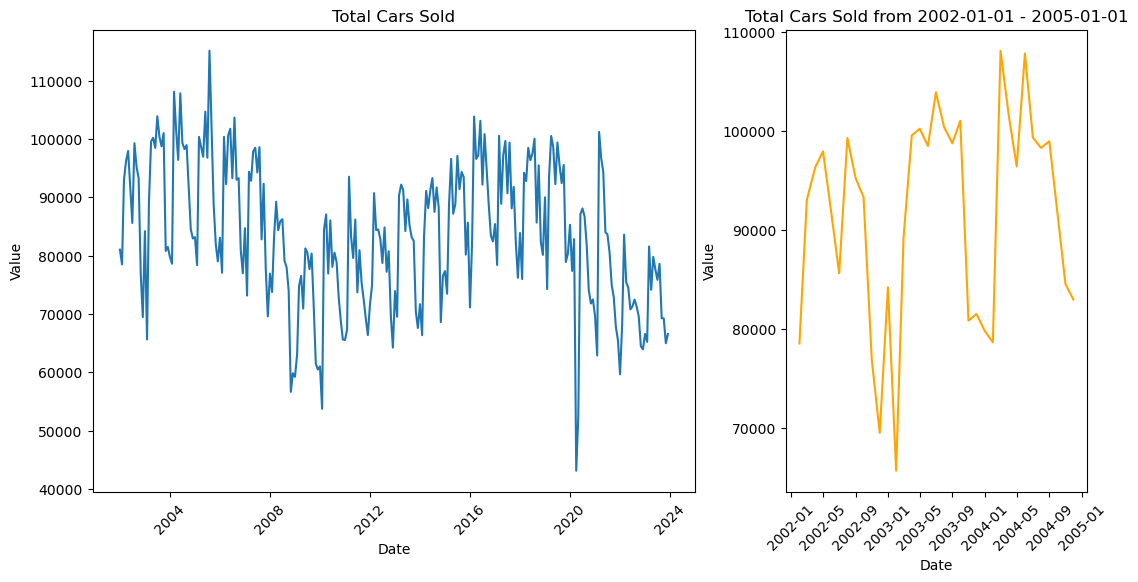

In [70]:
time_series_seasonal_analysis(total_cars_sold,'total_cars_sold','Total Cars Sold','2002-01-01','2005-01-01')

##### Initial observations : Total Cars Sold 2002-2024 (left)
- Irregularities : In 2020 there was a large irregularity in the number of cars sold, this is likely due to the shock economic factor of the Covid-19 Pandemic.
- Seasonality : There is a strong seasonality that is present, which is observed by the frequently occuring changes in cars sold each year.
- Cyclical : There is a downward and upward cyclical change that takes place over the years of data recorded.
- Trend : There seems to be a small decreasing trend in the number of cars sold.

##### Initial Observations : Total Cars Sold 2002-2005 (right)
- Seasonality : The seasonal pattern seems to be once every 12 periods which is a monthly basis.

#### Initial Seasonal Decomposition of Total Cars Sold

Linear Regression
Slope: -39.07646353228154
Intercept: 88841.9297891511


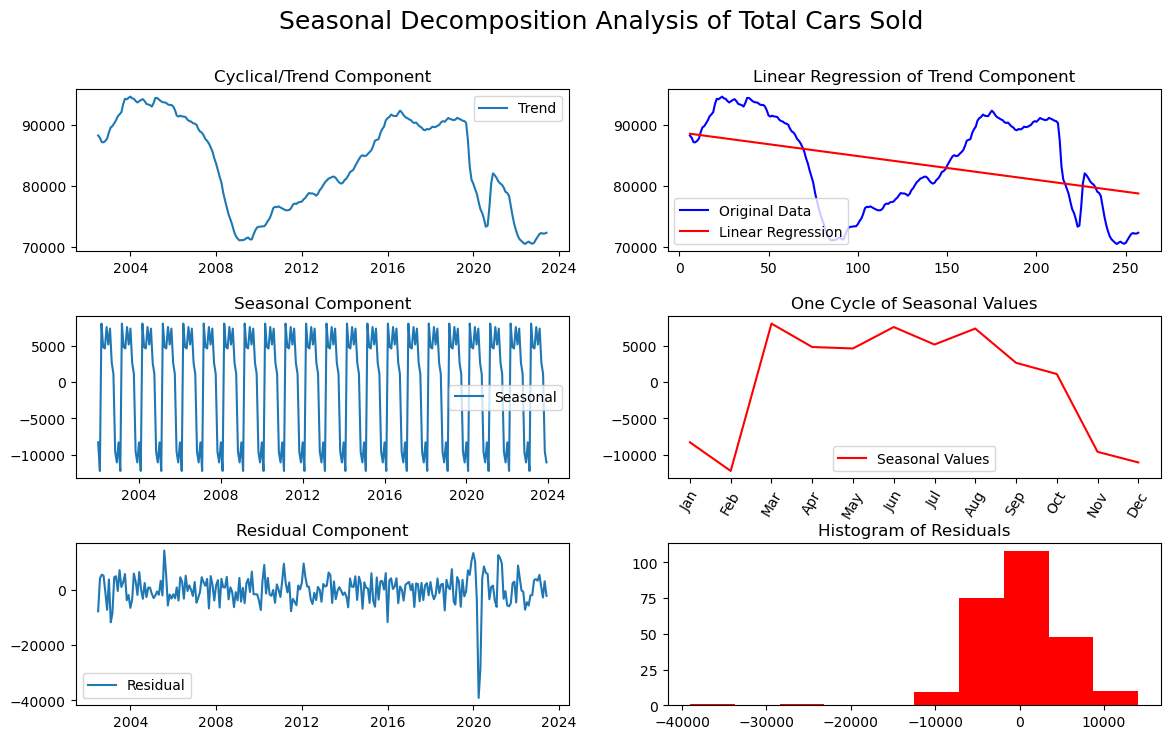

In [23]:
# using the periods found above do a seasonal decomposition of data
seasonal_decomposition_analysis(total_cars_sold,'Total Cars Sold',12)

This breakdown lists the fundamental information that is required to understand the data more indepth.

- Cyclical/Trend Component (Top Left) : This shows the moving average with a window of 12 hence why it represents the cyclical changes that take place and the trend.

- Linear Regression of Trend Component (Top Right) : With a slope of -39 it suggests that with each month there are 39 less cars sold per month than the last

- Seasonal Component (Middle Left) : This is the repetition of the average number of cars sold per month relative to the average across the year

- One Cycle of Seasonal Values (Middle Right): This gives a detailed view of one seasonal differencing where Jan, Feb, Nov and Dec (cold months) seem to have the lowest amount of cars sold on average

- Residual Component (Bottom Left) : Displays the error which is left over after adding the seasonal component with the moving average. Highlights irregularities in 2005 and 2020 but also the stationarity component of the decomposition

- Histogram of Residuals : The data closely follows a normal distribution with a few more data points falling below the average which might suggest that the decreasing trend is actually incorrect and should not be included.


### In-depth Seasonal Decomposition
This seasonal decomposition is going to use the knowledge that has been gained from the initial seasonal decomposition to build a more concrete understanding of each component. This needs to be performed so that mathematical modeling using the data can be used.

1. Remove irregularities: The initial decomposition displayed just how much the irregularities were impacting the data. By looking at those with a zscore greater than 2, remove these before continuing onto the next stages of decomposition.

#### Irregularity Removal

In [24]:
# create a wide data format of cars sold
monthly_total_cars_sold = create_monthly_data(total_cars_sold,'total_cars_sold',np.arange(len(total_cars_sold)),'2002','2024')

# create zscores of original data
zscore_monthly_total_cars_sold = (monthly_total_cars_sold-monthly_total_cars_sold.mean()) / monthly_total_cars_sold.std()
zscore_monthly_total_cars_sold

,January,February,March,April,May,June,July,August,September,October,November,December
2002,0.579946,0.968067,0.164563,0.593972,0.779738,0.087924,-0.325599,0.777937,0.983196,0.873445,0.382231,-0.372733
2003,0.9211,-0.875622,-0.284574,0.8474,0.96661,0.795587,1.665175,0.879298,1.350218,1.620085,0.870801,1.138864
2004,0.445323,0.985259,1.947288,1.002371,0.654391,1.781509,1.167291,0.687168,1.371814,0.736944,1.330918,1.320968
2005,0.811131,0.949586,1.032589,0.773596,0.699346,1.450971,0.892127,2.226313,1.674362,0.434535,1.014689,0.828029
2006,0.800858,0.761478,1.033416,0.282168,0.999178,1.141303,0.509031,1.179,0.752946,0.8718,0.883724,0.571827
2007,0.97722,0.201738,0.324792,0.327598,0.774734,0.798854,0.615332,0.715932,-0.314214,0.778349,0.490954,-0.356908
2008,0.136176,0.288127,-1.007968,0.048819,-0.332798,-0.528778,-0.255856,-1.062463,-0.818321,-0.998767,-2.13182,-1.581407
2009,-1.779042,-1.240377,-1.989193,-0.93582,-1.435655,-1.021107,-0.877558,-1.193777,-0.568354,-1.235103,-1.530426,-1.501909
2010,-1.585487,-2.57934,-0.850338,-0.118944,-0.943373,-0.515076,-1.145105,-0.934985,-0.72088,-1.098313,-0.61827,-0.853741
2011,-1.096302,-0.632929,0.224236,-0.421832,-0.724508,-0.499793,-1.620249,-0.897271,-1.091971,-1.13904,-0.569686,-0.758167


In [25]:
# create seasonal values
seasonal_values = monthly_total_cars_sold.mean() - total_cars_sold['total_cars_sold'].mean()

# remove irregularities
monthly_sales_data_irregularities_removed, expected_values = remove_irregularities(
    monthly_total_cars_sold, 
    zscore_monthly_total_cars_sold, 
    seasonal_values
)
monthly_sales_data_irregularities_removed

Found: 115136 at (2005, August), Replacing with: 101008
Found: 56645 at (2008, November), Replacing with: 67502
Found: 53741 at (2010, February), Replacing with: 62697
Found: 43120 at (2020, April), Replacing with: 80309
Found: 52407 at (2020, May), Replacing with: 80132
Found: 70783 at (2022, June), Replacing with: 77807


,January,February,March,April,May,June,July,August,September,October,November,December
2002,81033,78502,93019,96269,97936,91763,85602,99275,95225,93296,76878,69455
2003,84188,65633,89218,99538,100214,98477,103899,100385,98743,101014,80810,81491
2004,79788,78622,108106,101537,96408,107831,99323,98281,98950,91885,84513,82941
2005,83171,78373,100365,98586,96956,104695,96794,101008,101850,88759,81968,79016
2006,83076,77060,100372,92247,100611,101757,93273,103667,93018,93279,80914,76976
2007,84707,73153,94375,92833,97875,98508,94250,98596,82789,92313,77753,69581
2008,76929,73756,83096,89237,84374,85912,86243,79121,77957,73943,67502,59831
2009,59217,63087,74792,76536,70930,81241,80529,77683,80353,71500,61485,60464
2010,61007,62697,84430,87073,76931,86042,78070,80517,78891,72914,68826,65625
2011,65531,67327,93524,83166,79599,86187,73703,80930,75334,72493,69217,66386


The data values which had a z score greater than or less than 2 has been removed. Removing the irregularities as the first step for seasonal decomposition allows for a more general understanding but possibly less representative of what was found in the recorded data. This a suitable sacrifice with the goal of forecasting future data.

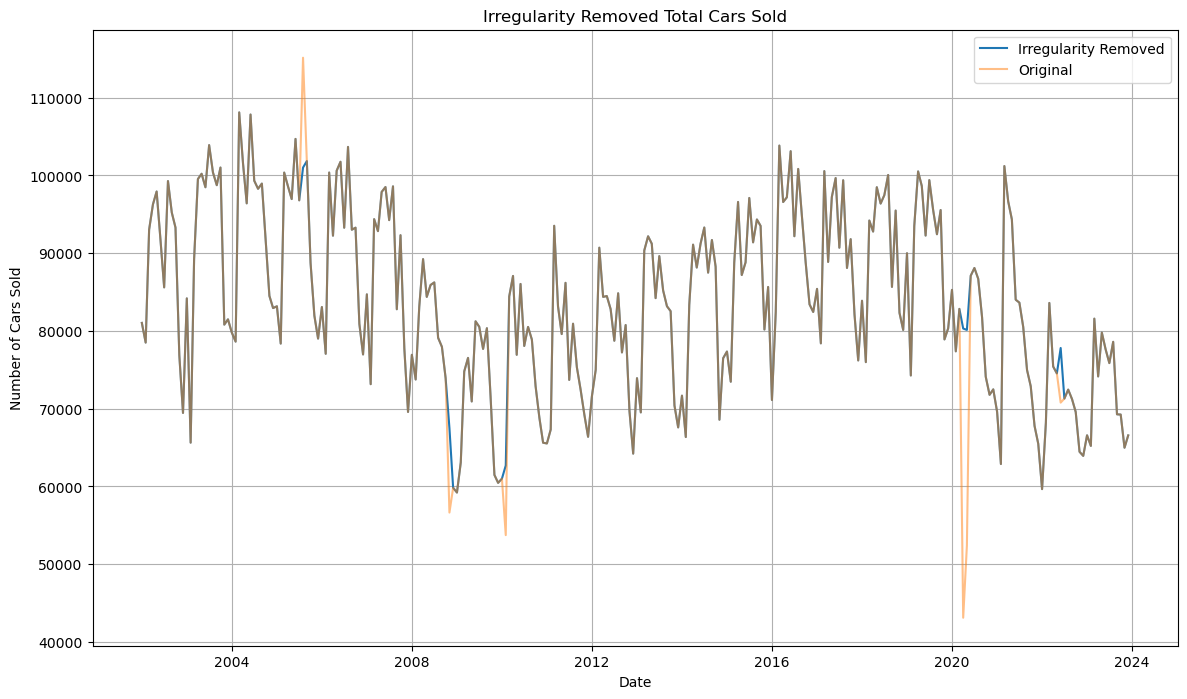

In [26]:
# plot the data before and after the removal of the irregularity 

# convert the wide data to long data
components_removed_total_cars_sold = convert_to_long_format(monthly_sales_data_irregularities_removed,'2002-01-01','2024-01-01','total_cars_sold','M')

# plot the two series comparison
plot_multiple_series_one_xvalues(total_cars_sold.index,
                                [components_removed_total_cars_sold['total_cars_sold'],total_cars_sold['total_cars_sold']],
                                ['Irregularity Removed','Original'],'Irregularity Removed Total Cars Sold','Date',
                                'Number of Cars Sold',[1,0.5])


#### Seasonality Understanding
Using the new data with irregularities removed, look at the seasonality

In [27]:
# look at the difference between the seasonal values after irregularities removed
monthly_sales_data_irregularities_removed.mean() - monthly_total_cars_sold.mean()

January         0.000000
February      407.090909
March           0.000000
April        1690.409091
May          1260.227273
June          319.272727
July            0.000000
August       -642.181818
September       0.000000
October         0.000000
November      493.500000
December        0.000000
dtype: float64

The new seasonal values are higher due to the removal of certain data values such as in April and May in 2020 where the number of cars sold were irregularly low.

January      -8178.636364
February    -11696.318182
March         7778.045455
April         6449.409091
May           5842.818182
June          7399.818182
July          4746.272727
August        6265.454545
September     1952.545455
October        418.954545
November     -9552.954545
December    -11425.409091
dtype: float64


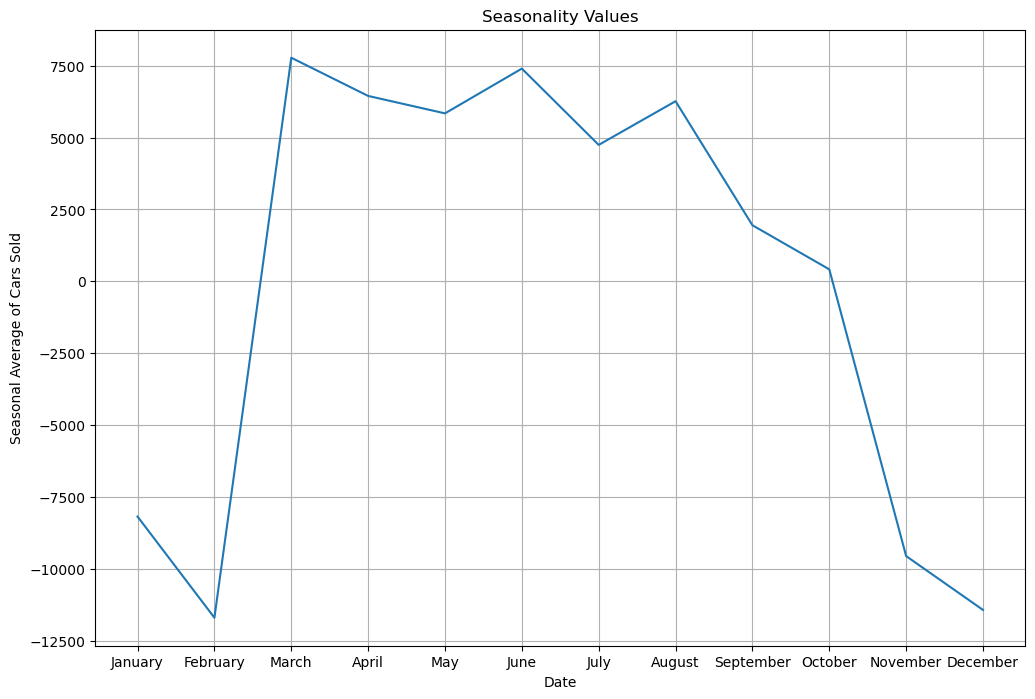

In [28]:
# print out the new seasonal values
seasonal_values_irregularity_removed = monthly_sales_data_irregularities_removed.mean() - components_removed_total_cars_sold['total_cars_sold'].mean()
print(seasonal_values_irregularity_removed)
line_series(seasonal_values_irregularity_removed.index,seasonal_values_irregularity_removed.values,
            'Seasonality Values','Date','Seasonal Average of Cars Sold',True)

In [29]:
# create deseasonlised data by removing seasonal values
components_removed_total_cars_sold.reset_index(inplace=True)
components_removed_total_cars_sold.rename(columns={'index':'date'},inplace=True)
components_removed_total_cars_sold['month'] = components_removed_total_cars_sold['date'].dt.month_name()
components_removed_total_cars_sold

,date,total_cars_sold,month
0,2002-01-01,81033,January
1,2002-02-01,78502,February
2,2002-03-01,93019,March
3,2002-04-01,96269,April
4,2002-05-01,97936,May
...,...,...,...
259,2023-08-01,78601,August
260,2023-09-01,69278,September
261,2023-10-01,69248,October
262,2023-11-01,64980,November


In [30]:
# map the seasonal values 
components_removed_total_cars_sold['seasonal_value'] = components_removed_total_cars_sold['month'].map(seasonal_values_irregularity_removed)
components_removed_total_cars_sold['deseasonlised_total_cars_sold'] = components_removed_total_cars_sold['total_cars_sold'] - components_removed_total_cars_sold['seasonal_value']
components_removed_total_cars_sold.drop(columns={'month','seasonal_value'})

,date,total_cars_sold,deseasonlised_total_cars_sold
0,2002-01-01,81033,89211.636364
1,2002-02-01,78502,90198.318182
2,2002-03-01,93019,85240.954545
3,2002-04-01,96269,89819.590909
4,2002-05-01,97936,92093.181818
...,...,...,...
259,2023-08-01,78601,72335.545455
260,2023-09-01,69278,67325.454545
261,2023-10-01,69248,68829.045455
262,2023-11-01,64980,74532.954545


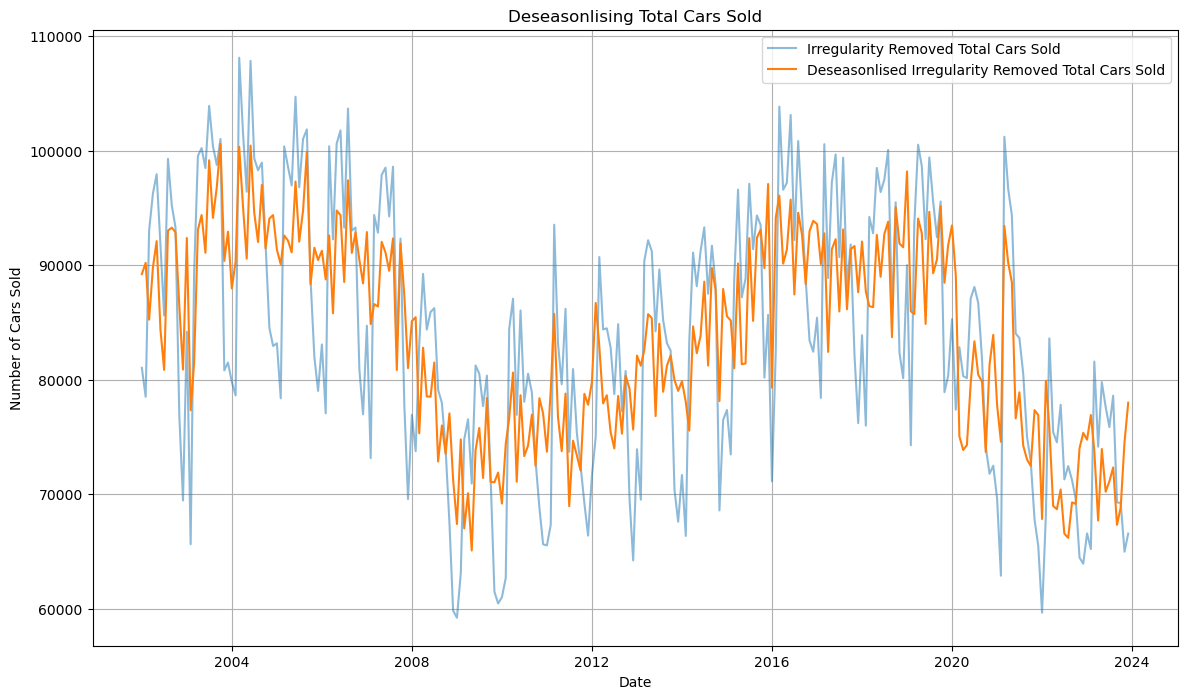

In [31]:
# plot the data which has removed 
plot_multiple_series_one_xvalues(components_removed_total_cars_sold['date'],
                                 [components_removed_total_cars_sold['total_cars_sold'],
                                  components_removed_total_cars_sold['deseasonlised_total_cars_sold']],
                                  ['Irregularity Removed Total Cars Sold','Deseasonlised Irregularity Removed Total Cars Sold'],
                                  'Deseasonlising Total Cars Sold','Date','Number of Cars Sold',[0.5,1])

##### Confidence Intervals of Seasonality

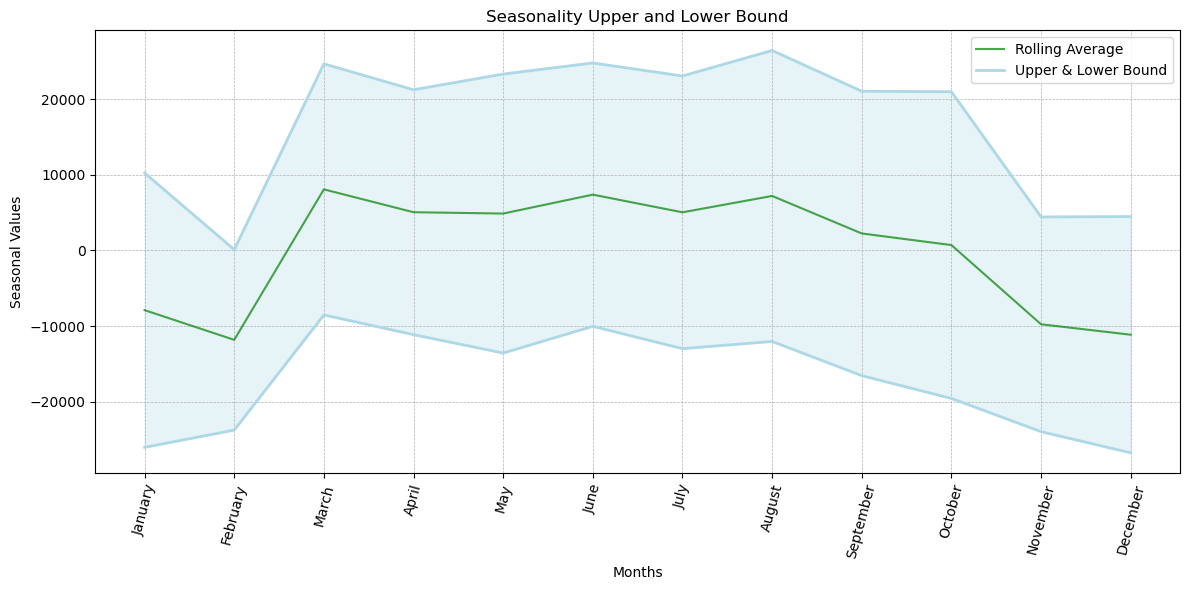

In [32]:
# create upper seasonal value
upper_seasonal_value = seasonal_values + (1.96 * monthly_sales_data_irregularities_removed.std())

# create lower seasonal value
lower_seasonal_value = seasonal_values - (1.96 * monthly_sales_data_irregularities_removed.std())

plot_confidence_intervals(months,upper_seasonal_value,lower_seasonal_value,
                          'Seasonality Upper and Lower Bound','Months','Seasonal Values',
                          seasonal_values,False,True,False)

#### Cyclical Understanding

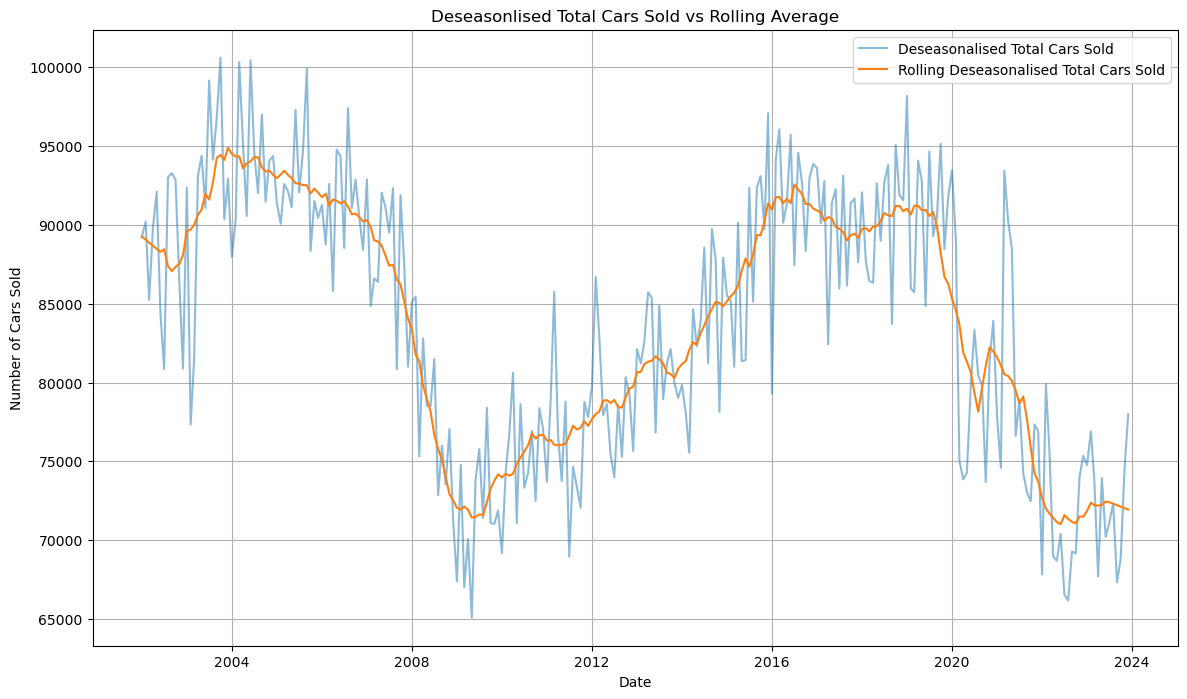

In [33]:
# create rolling average of deseasonlised data
# use savgol smooth function from above with a window of 12 (due to seasonality) and polyorder 1
total_cars_sold_rolling_average = savgol_smooth(components_removed_total_cars_sold['deseasonlised_total_cars_sold'],12,1)

# plot rolling average and deseasonlised data
plot_multiple_series_one_xvalues(components_removed_total_cars_sold['date'],
            [components_removed_total_cars_sold['deseasonlised_total_cars_sold'],
            total_cars_sold_rolling_average],
            ['Deseasonalised Total Cars Sold','Rolling Deseasonalised Total Cars Sold'],
            'Deseasonlised Total Cars Sold vs Rolling Average',
            'Date','Number of Cars Sold',[0.5,1])

The movement of deseasonalised total cars sold sems to follow a consistient pattern over the past 22 years. It seems to look quite sinusoidal. The next step is to understand the parameters that make up that sinusoidal cycle.

##### Parameter Estimation
Using a sinusoidal function, model the total cars sold from 2002-2024 using estimation of parameters. 

In [34]:
from sympy import symbols, sin, pi
from sympy import init_printing

# Initialize pretty printing
init_printing()

# Define symbols
A,B,x,C,D = symbols('A,B,x,C,D')

# Define an expression
expr = A * sin(B * (x - C)) + D

# Display the expression
expr

- A : Amplitude - The peak deviation from the central value.

- T : Period - The number of intervals in between each sinsusoidal period of the graph

- B : Angular Frequency - Number of cycles a function completes per unit interval

- C : Phase Shift - Represents the horizontal shift of the function along the x axes

- D : Vertical Shift - Moves up or down the entire function

In [35]:
# sine function
def sine_function(x, A, B, C, D):
    return A * np.sin(B * (x - C)) + D

In [36]:
# amplitude can be found by getting the difference between max and min divided by 2
A = (total_cars_sold_rolling_average.max() - total_cars_sold_rolling_average.min())/2

# period is found by the years between the cycles (2016-2004 = 12)
T = 12 * 12 # times 12 to represent 12 lots of 12 months

# find angular frequency from period
B = (2 * np.pi) / T

# the sinusoidal graph needs to be shifted back 2 years
C = 2

# the vertical shift or the average of the function
D = total_cars_sold_rolling_average.mean()

In [37]:
# define x values
sine_x = np.arange(0,len(total_cars_sold_rolling_average))

# find y values
total_cars_sold_sine = sine_function(sine_x,A,B,C,D)

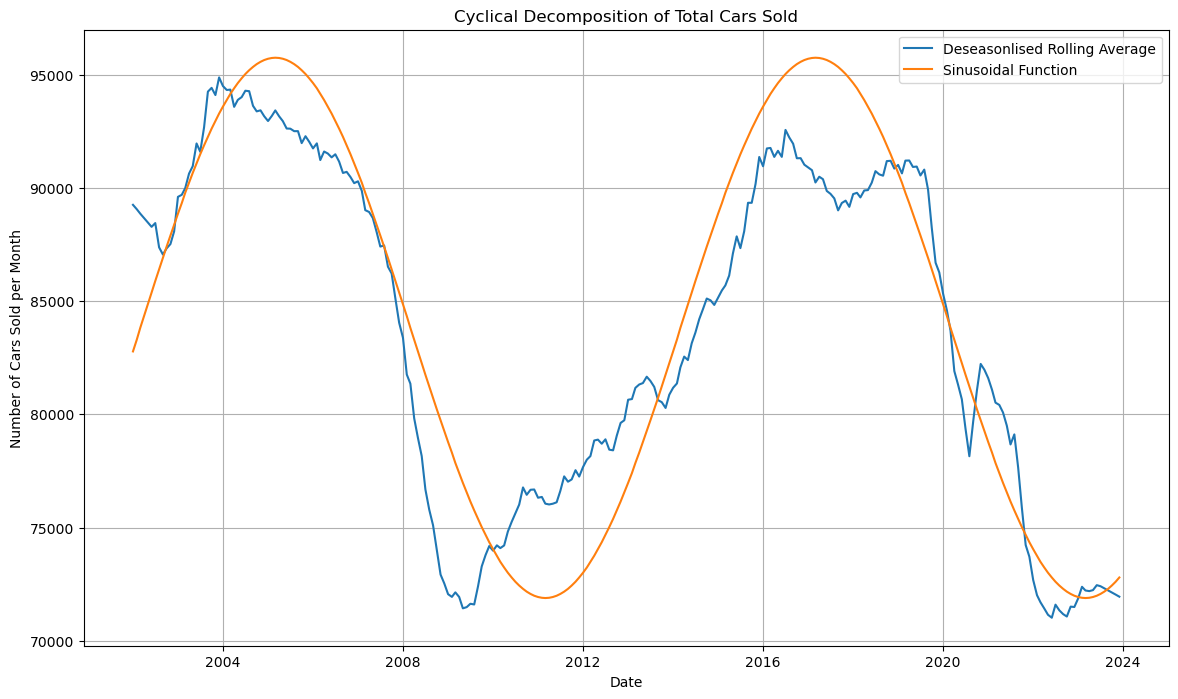

In [38]:
# plot multiple series
plot_multiple_series_one_xvalues(total_cars_sold.index,
                                 [total_cars_sold_rolling_average,total_cars_sold_sine],
                                 ['Deseasonlised Rolling Average','Sinusoidal Function'],
                                 'Cyclical Decomposition of Total Cars Sold','Date',
                                 'Number of Cars Sold per Month')

In [39]:
# evaluation 
mae_sine_total_cars_sold = mean_absolute_error(total_cars_sold_sine,total_cars_sold_rolling_average)

print(f'Mean Absolute Error of Total Cars Sold: {mae_sine_total_cars_sold}')

Mean Absolute Error of Total Cars Sold: 2546.9275458839766


##### Parameter Optimisation
Using scipy.optimise find the optimal values of the parameters of the sinusoidal graph

In [40]:
# use the function created in functions under optimisation

# create initial guess list of parameters
initial_guess_sine_total_cars_sold = [A,B,C,D]

# fit the curve
popt,pcov = fit_curve(sine_function,sine_x,total_cars_sold_rolling_average,initial_guess_sine_total_cars_sold)

# create a list of string letters
param_letters = ['A','B','C','D']

# create a list of string names
param_names = ['Amplitude','Angular Frequency','Horizontal Shift','Vertical Shift']

# get standard deviation 
std_devs = np.sqrt(np.diag(pcov)).tolist()

# print out the relevant data
for param_letter,param_name,optimal_value,std_dev in zip(param_letters,param_names,popt,std_devs):
    print(f'{param_name} ({param_letter}) : {optimal_value:.4f} ± {std_dev:.4f}')

Amplitude (A) : 9861.4121 ± 196.5892
Angular Frequency (B) : 0.0416 ± 0.0003
Horizontal Shift (C) : -6.4306 ± 1.0623
Vertical Shift (D) : 83165.0948 ± 146.5875


The standard deviation is very small for ampltiude, angular frequency and vertical shift however the horizontal shift is quite large. The small standard deviation suggests that those values do not show high error across the model which is seen by the small differences. However the largest differences come in the optimisation of the timing of this model. That is because the movement in declines and recoveries are actually quite different, suggesting that it does not occur a constant basis and there are other factors that play into the reasoning for the changes in car sales besides cyclical patterns (this will be explored in the economic conditions chapter).

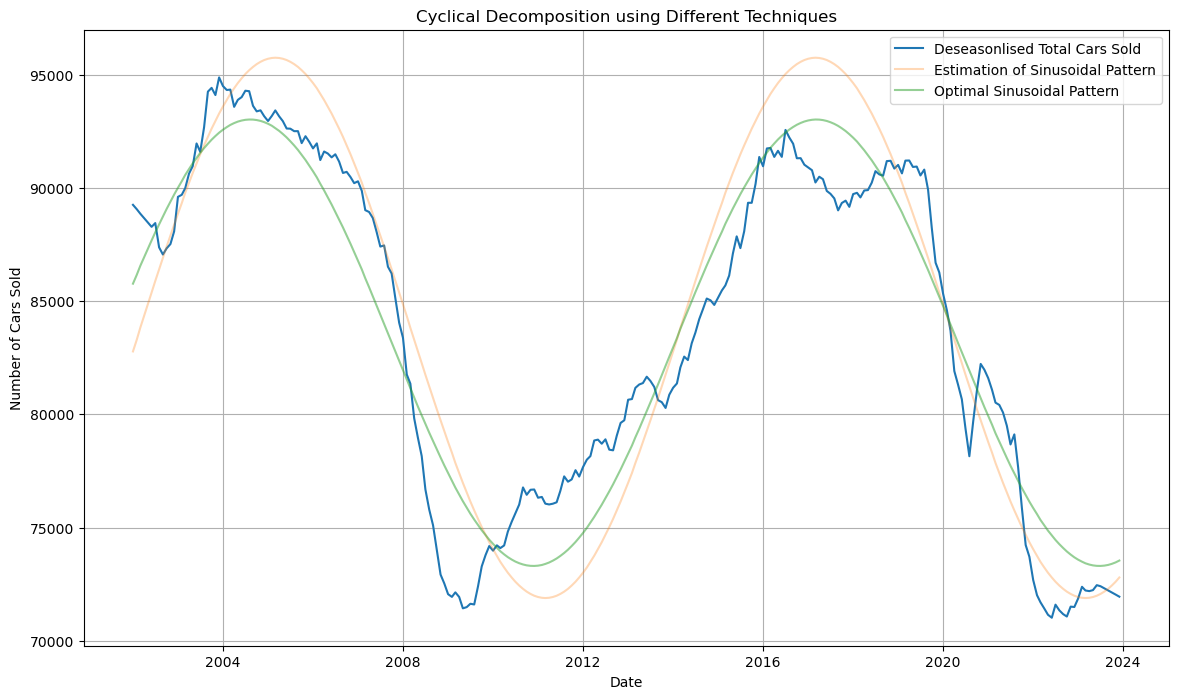

Parameter Estimation MAE: 2546.9275458839766
Parameter Optimisation MAE: 1946.1361513136428


In [41]:
# create new sine function
total_cars_sold_sine_optimal = sine_function(sine_x,*popt)

# plot the comparisons
plot_multiple_series_one_xvalues(total_cars_sold.index,
                                 [total_cars_sold_rolling_average,total_cars_sold_sine,total_cars_sold_sine_optimal],
                                 ['Deseasonlised Total Cars Sold','Estimation of Sinusoidal Pattern','Optimal Sinusoidal Pattern'],
                                 'Cyclical Decomposition using Different Techniques','Date','Number of Cars Sold',
                                 [1,0.3,0.5])

# display two mean absolute error
mae_sine_optimal_total_cars_sold = mean_absolute_error(total_cars_sold_sine_optimal,total_cars_sold_rolling_average)

print(f'Parameter Estimation MAE: {mae_sine_total_cars_sold}')
print(f'Parameter Optimisation MAE: {mae_sine_optimal_total_cars_sold}')

There is a 20% improvement in the accuracy of the model through using optimisation techniques. This has accuretly depicted the model however it has likely led to overfitting. For more effective modeling use confidence intervals.

It is also important to note the difficulty in finding the trough for both the estimation and model optimisation. This suggests that the vertical shift suggests a complex system which has many influences on the pattern.

##### Defining Confidence Intervals for Model

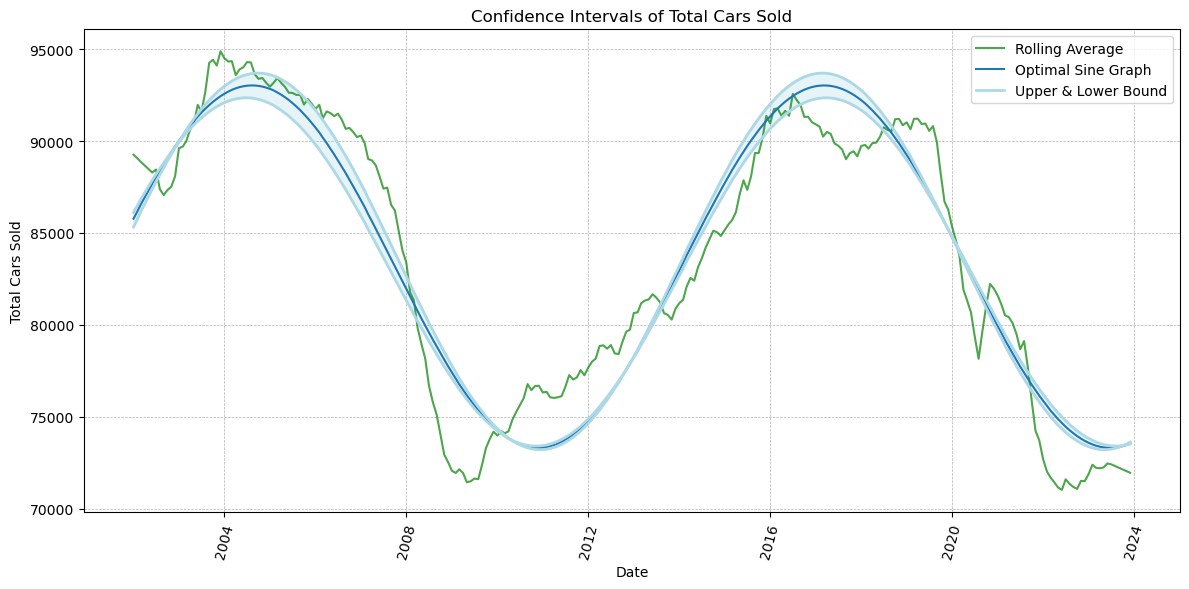

A (Amplitude):
  Optimal Value: 9861.41212474295
  Upper Bound: 10246.71991036392
  Lower Bound: 9476.104339121981

B (Angular Frequency):
  Optimal Value: 0.04162872372276663
  Upper Bound: 0.04219641337575745
  Lower Bound: 0.04106103406977581

C (Horizontal Shift):
  Optimal Value: -6.430599802650237
  Upper Bound: -4.348614255502506
  Lower Bound: -8.512585349797968

D (Vertical Shift):
  Optimal Value: 83165.09476278716
  Upper Bound: 83452.40091791896
  Lower Bound: 82877.78860765537



In [42]:
from scipy.stats import norm

# define parameter names
param_names = ['Amplitude','Angular Frequency','Horizontal Shift','Vertical Shift']

# define confidence level
confidence_level = 0.95
# calculate z-score for the given confidence level
z_score = norm.ppf((1 + confidence_level) / 2)

# create a dictionary to store the upper and lower bound data
param_dict = {}

# store the data
for symbol, name, param, std in zip(param_letters, param_names, popt, std_devs):
    param_dict[symbol] = {
        'Parameter Name': name,
        'Optimal Value': param,
        'Upper Bound': param + (z_score * std),
        'Lower Bound': param - (z_score * std)
    }

# store upper and lower parameters
params_upper = []
params_lower = []
for letter in param_letters:
    params_upper.append(param_dict[letter]['Upper Bound'])

    params_lower.append(param_dict[letter]['Lower Bound'])

# create sine functions of stored parameters
upper_sine = sine_function(sine_x,*params_upper)
lower_sine = sine_function(sine_x,*params_lower)

plot_confidence_intervals(total_cars_sold.index,upper_sine,lower_sine,
                          'Confidence Intervals of Total Cars Sold','Date','Total Cars Sold',
                          total_cars_sold_rolling_average,total_cars_sold_sine_optimal,True,True)

# print out the relevant data that will be plotted
for symbol, details in param_dict.items():
    print(f"{symbol} ({details['Parameter Name']}):")
    print(f"  Optimal Value: {details['Optimal Value']}")
    print(f"  Upper Bound: {details['Upper Bound']}")
    print(f"  Lower Bound: {details['Lower Bound']}")
    print()

The confidence intervals have been created and added to contrast with the optimal sine graph. These confidence intervals can be utilised when forecasting into the future. However, they do show that the upper and lower bounds are relatively close together. The confidence intervals can be used for future forecasting as well.

##### Remove Optimal Cyclical Component from Data

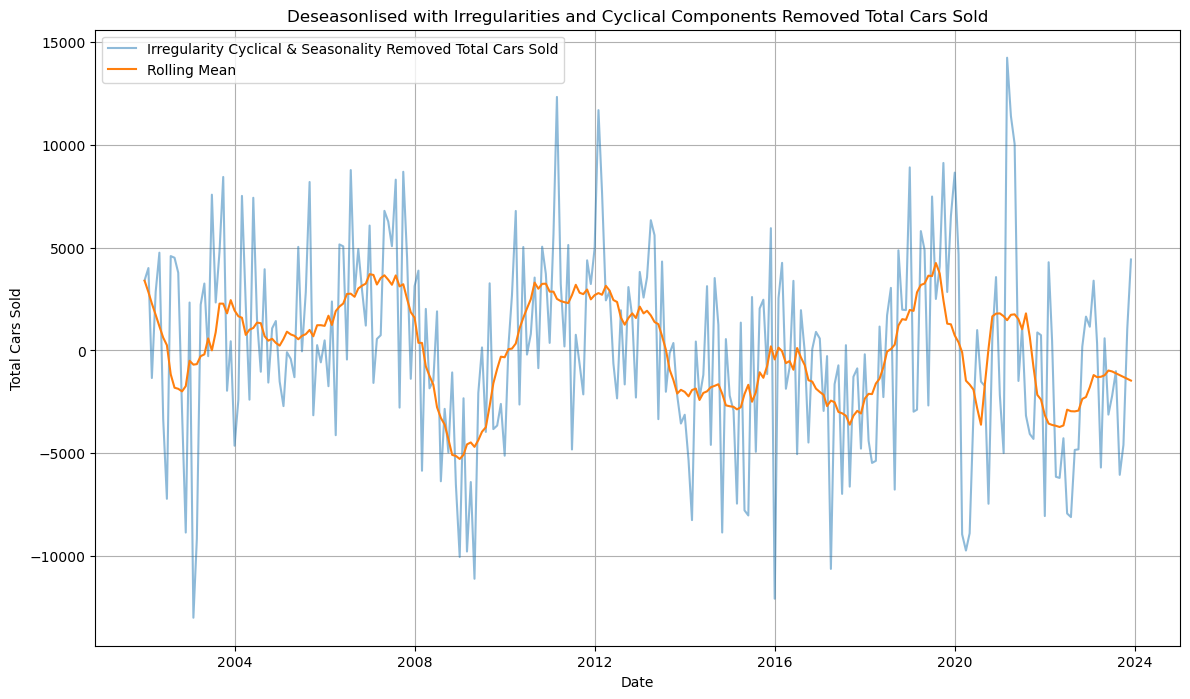

In [43]:
# assign a new column to the cyclical component 
components_removed_total_cars_sold['cyclical_component'] = total_cars_sold_sine_optimal - total_cars_sold_sine_optimal.mean()

# remove the cyclical component from the deseasonlised car sold
components_removed_total_cars_sold['cyclical_deseasonlised_total_cars_sold'] = components_removed_total_cars_sold['deseasonlised_total_cars_sold'] - components_removed_total_cars_sold['cyclical_component'] - components_removed_total_cars_sold['deseasonlised_total_cars_sold'].mean()

plot_multiple_series_one_xvalues(components_removed_total_cars_sold['date'],
                                [components_removed_total_cars_sold['cyclical_deseasonlised_total_cars_sold'],
                                savgol_smooth(components_removed_total_cars_sold['cyclical_deseasonlised_total_cars_sold'],12,1)],
                                ['Irregularity Cyclical & Seasonality Removed Total Cars Sold','Rolling Mean'],
                                'Deseasonlised with Irregularities and Cyclical Components Removed Total Cars Sold',
                                'Date','Total Cars Sold',[0.5,1])

Looking at the data there does seem to be a dip in 2008-2009 which is likely because the drop is steeper than what is depicted by the sinusoidal graph. This suggests that the drop was faster than what was expected. The next component is to look at is the linear trend of the data.

#### Trend Analysis

In [44]:
# adf test prior to detrending
adf_test(components_removed_total_cars_sold['cyclical_deseasonlised_total_cars_sold'])

ADF Statistic:  -3.824389491321737
P-Value:  0.002667407293301615
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


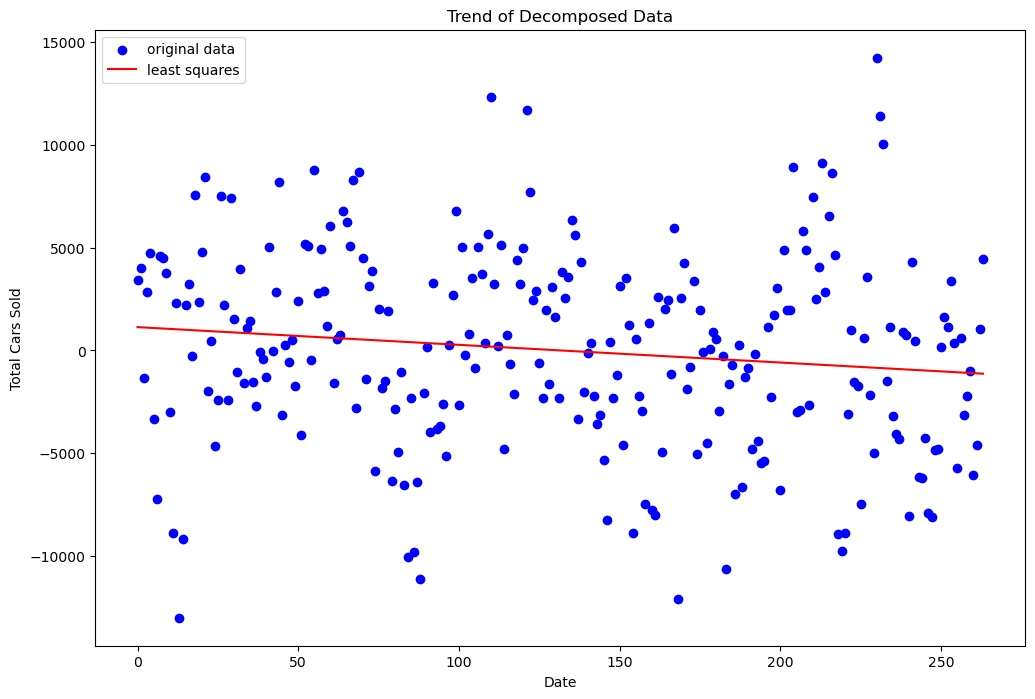

In [45]:
least_squares_line(components_removed_total_cars_sold.index ,components_removed_total_cars_sold['cyclical_deseasonlised_total_cars_sold'],
                   'Trend of Decomposed Data','Date','Total Cars Sold')

In [46]:
# detrend data
components_removed_total_cars_sold['decomposed_data'] = components_removed_total_cars_sold['cyclical_deseasonlised_total_cars_sold'] - 8.6 * np.arange(1,len(components_removed_total_cars_sold)+1)

# look at the adf test
adf_test(components_removed_total_cars_sold['decomposed_data'])

ADF Statistic:  -3.272913416404266
P-Value:  0.016133522176508926
Critical Value: 
	1%: -3.46
	5%: -2.87
	10%: -2.57


The detrending component makes the ADF test performance decrease. Therefore the decision to not detrend the data is going to be made.

#### Model of Total Cars Sold from Seasonal Decomposition

In [47]:
components_removed_total_cars_sold['constructed_data'] = components_removed_total_cars_sold['seasonal_value'] + components_removed_total_cars_sold['cyclical_component'] + components_removed_total_cars_sold['total_cars_sold'].mean()
components_removed_total_cars_sold['constructed_data']

0      77622.366028
1      74498.206390
2      94360.890670
3      93414.700572
4      93184.018884
           ...     
259    79610.939545
260    75328.697019
261    73842.781539
262    63935.474134
263    62144.435596
Name: constructed_data, Length: 264, dtype: float64

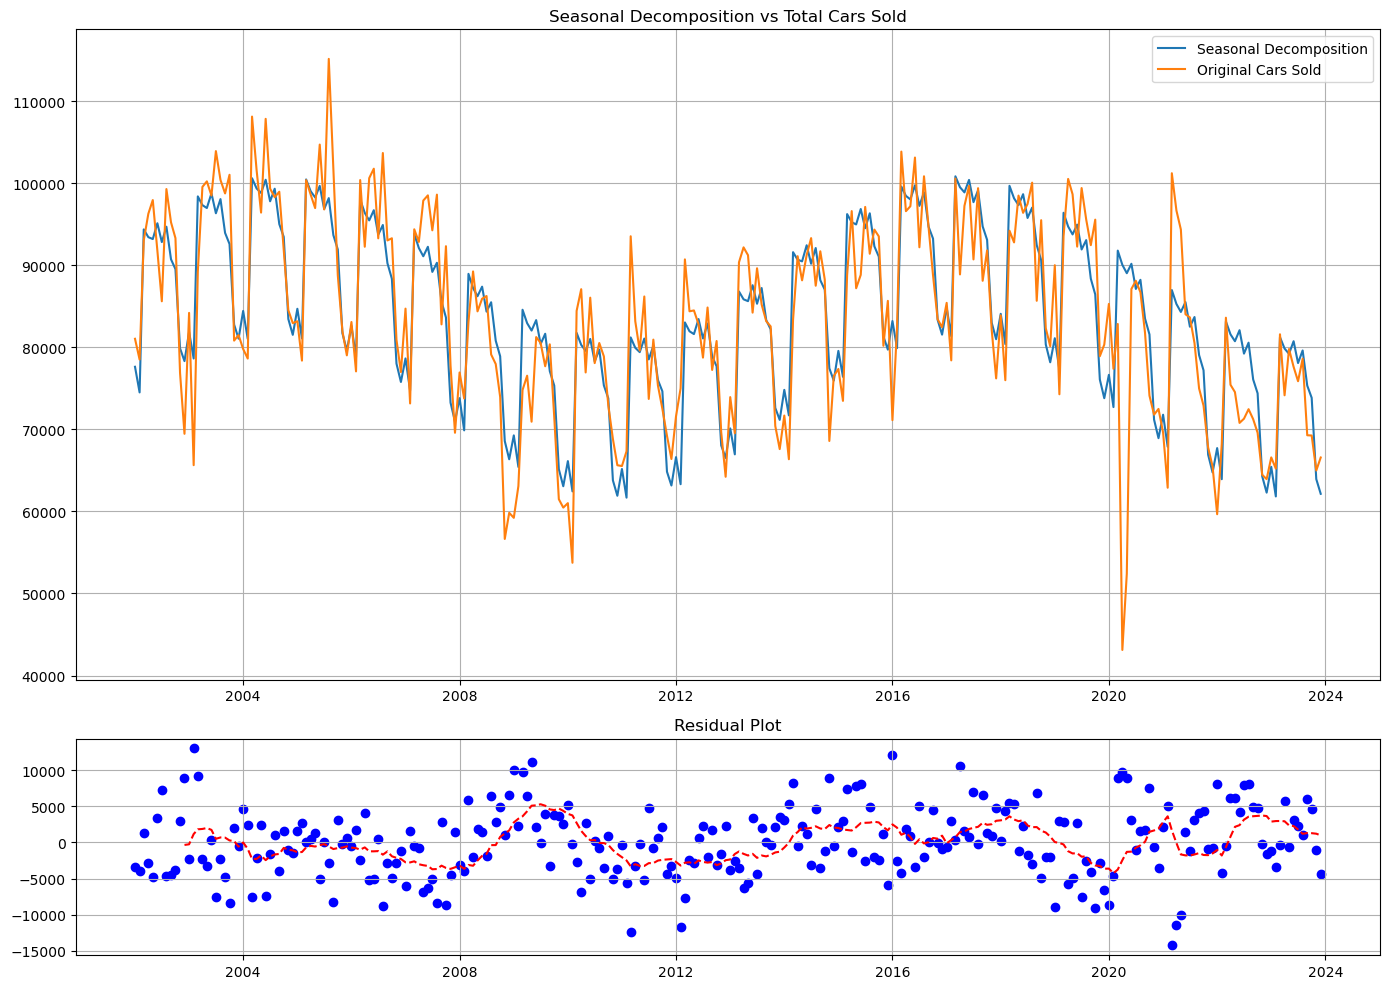

mean absolute error: 3788.822082085595


In [48]:
# create a residual plot of calculated and original number of cars sold
residual = components_removed_total_cars_sold['constructed_data'] - components_removed_total_cars_sold['total_cars_sold']

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # Define the grid layout

# Create subplots with the defined grid
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# Plot the standard deviation of month to month
ax0.plot(components_removed_total_cars_sold['date'], 
         components_removed_total_cars_sold['constructed_data'],label='Seasonal Decomposition')
ax0.plot(components_removed_total_cars_sold['date'], 
         total_cars_sold['total_cars_sold'],label='Original Cars Sold')
ax0.set_title('Seasonal Decomposition vs Total Cars Sold')
ax0.grid()
ax0.legend()

# Plot the standard deviation from year to year
ax1.scatter(components_removed_total_cars_sold['date'], residual,color='blue')
ax1.set_title('Residual Plot')
ax1.grid()

ax1.plot(components_removed_total_cars_sold['date'],residual.rolling(12).mean(),color='red',linestyle='--')

plt.tight_layout()
plt.show()

print('mean absolute error:',mean_absolute_error(components_removed_total_cars_sold['constructed_data'],components_removed_total_cars_sold['total_cars_sold']))

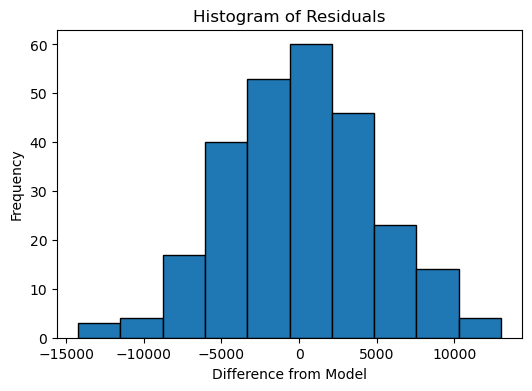

In [49]:
fig, ax = plt.subplots(figsize=(6, 4))
plot_histogram(ax,residual,10,'Histogram of Residuals','Difference from Model','Frequency')

Observance of the histogram of the residual displays a normal distribution. This confirms that the data is stationary with an equal spread of data going above and below the model. With a MAE of 3788.82 when the average value is around 88,000 shows quite an accurate representation of the data. Forecasting the data is the next step

### Forecast Total Cars Sold using Seasonal Decomposition

#### Forecast Optimal Values

In [50]:
optimal_forecast = pd.DataFrame({'date':(pd.date_range('2002-01-01','2040-01-01',freq='M')-pd.offsets.MonthEnd(1) + pd.DateOffset(days=1))})

# create x values for cyclical sine function
sine_x_forecast = np.arange(1,len(optimal_forecast)+1)
optimal_forecast['cyclical'] = sine_function(sine_x_forecast,popt[0],popt[1],popt[2],0) 

# create month column to map to
optimal_forecast['month'] = optimal_forecast['date'].dt.month_name()

# map the values
optimal_forecast['seasonal'] = optimal_forecast['month'].map(seasonal_values)

# drop the month column
optimal_forecast.drop(columns='month',inplace=True)

# add the vertical shift
optimal_forecast['average'] = components_removed_total_cars_sold['total_cars_sold'].mean()

# create prediction value
optimal_forecast['prediction'] = optimal_forecast['cyclical'] + optimal_forecast['seasonal'] + optimal_forecast['average']

optimal_forecast

,date,cyclical,seasonal,average,prediction
0,2002-01-01,3001.982109,-7884.609848,83848.272727,78965.644988
1,2002-02-01,3390.302753,-11809.382576,83848.272727,75429.192905
2,2002-03-01,3772.749019,8072.071970,83848.272727,95693.093716
3,2002-04-01,4148.658240,5053.026515,83848.272727,93049.957482
4,2002-05-01,4517.379080,4876.617424,83848.272727,93242.269231
...,...,...,...,...,...
451,2039-08-01,2289.685314,7201.662879,83848.272727,93339.620920
452,2039-09-01,2686.885413,2246.571970,83848.272727,88781.730110
453,2039-10-01,3079.429945,712.981061,83848.272727,87640.683733
454,2039-11-01,3466.638747,-9752.428030,83848.272727,77562.483444


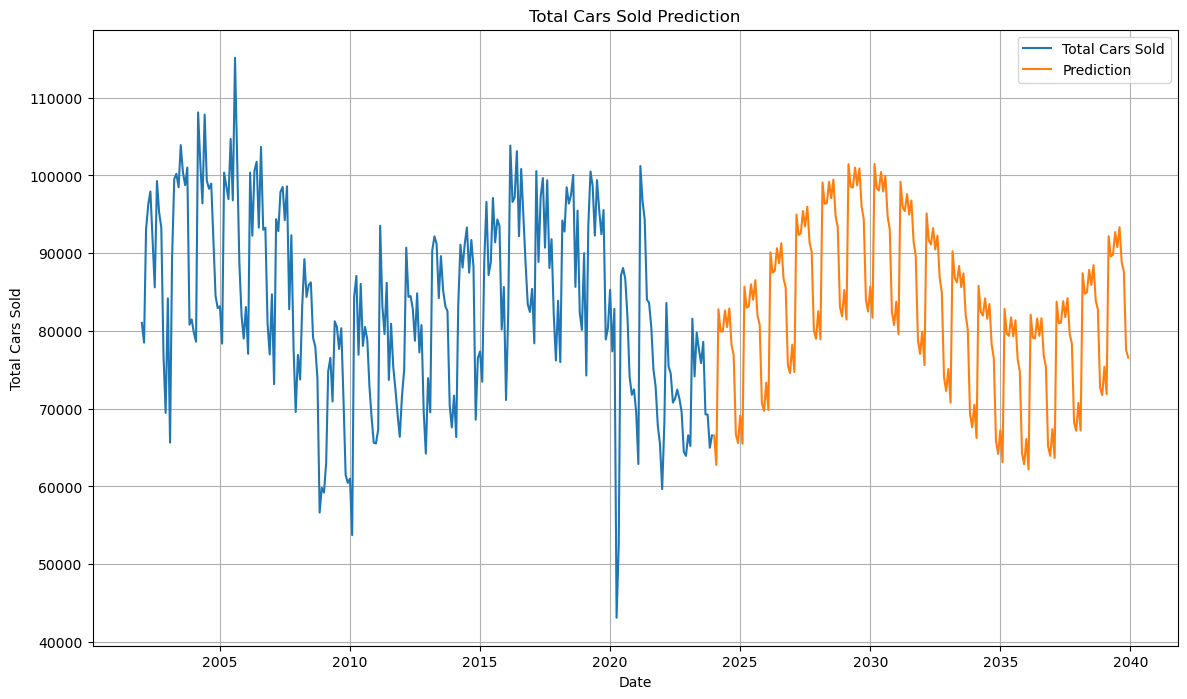

In [51]:
plot_multiple_series_multiple_xvalues([total_cars_sold.index,optimal_forecast['date'].iloc[264:]],
                                      [total_cars_sold['total_cars_sold'],optimal_forecast['prediction'].iloc[264:]],
                                      ['Total Cars Sold','Prediction'],'Total Cars Sold Prediction',
                                      'Date','Total Cars Sold',[1,1])

#### Forecast with Upper and Lower Bound

In [52]:
# create a dataframe with upper bounds
forecast_upper = pd.DataFrame({'date':(pd.date_range('2002-01-01','2040-01-01',freq='M')-pd.offsets.MonthEnd(1) + pd.DateOffset(days=1))})

forecast_upper['month'] = forecast_upper['date'].dt.month_name()

forecast_upper['seasonal'] = forecast_upper['month'].map(upper_seasonal_value)

forecast_upper.drop(columns='month',inplace=True)

forecast_upper['cyclical'] = sine_function(sine_x_forecast,*params_upper)

forecast_upper['prediction_upper'] = forecast_upper['cyclical'] + forecast_upper['seasonal']

forecast_upper

,date,seasonal,cyclical,prediction_upper
0,2002-01-01,10241.533335,85745.424152,95986.957486
1,2002-02-01,114.485888,86164.667551,86279.153439
2,2002-03-01,24659.330715,86579.082374,111238.413090
3,2002-04-01,21232.851501,86987.930851,108220.782352
4,2002-05-01,23306.836504,87390.485119,110697.321623
...,...,...,...,...
451,2039-08-01,26424.713993,87505.982573,113930.696566
452,2039-09-01,21033.668827,87899.359825,108933.028652
453,2039-10-01,20973.442403,88284.820275,109258.262678
454,2039-11-01,4433.905036,88661.677699,93095.582736


In [53]:
forecast_lower = pd.DataFrame({'date':(pd.date_range('2002-01-01','2040-01-01',freq='M')-pd.offsets.MonthEnd(1) + pd.DateOffset(days=1))})

forecast_lower['month'] = forecast_lower['date'].dt.month_name()

forecast_lower['seasonal'] = forecast_lower['month'].map(lower_seasonal_value)

forecast_lower.drop(columns='month',inplace=True)

forecast_lower['cyclical'] = sine_function(sine_x_forecast,*params_lower)

forecast_lower['prediction_lower'] = forecast_lower['cyclical'] + forecast_lower['seasonal']

forecast_lower

,date,seasonal,cyclical,prediction_lower
0,2002-01-01,-26010.753032,86485.721900,60474.968869
1,2002-02-01,-23733.251039,86842.372273,63109.121233
2,2002-03-01,-8515.186776,87192.339262,78677.152487
3,2002-04-01,-11126.798470,87535.032905,76408.234434
4,2002-05-01,-13553.601656,87869.875497,74316.273841
...,...,...,...,...
451,2039-08-01,-12021.388236,83441.918299,71420.530063
452,2039-09-01,-16540.524888,83829.742209,67289.217321
453,2039-10-01,-19547.480281,84215.961342,64668.481061
454,2039-11-01,-23938.761097,84599.924622,60661.163525


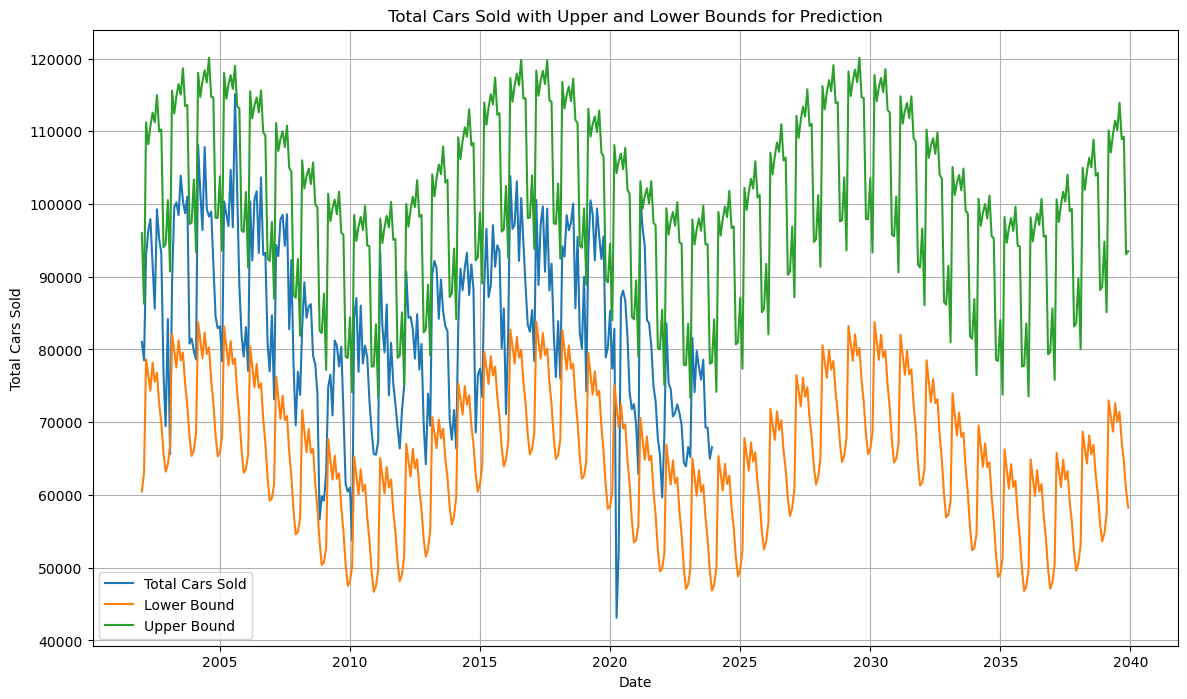

In [54]:
plot_multiple_series_multiple_xvalues([total_cars_sold.index,forecast_lower['date'],forecast_upper['date']],
                                      [total_cars_sold['total_cars_sold'],forecast_lower['prediction_lower'],
                                       forecast_upper['prediction_upper']],['Total Cars Sold','Lower Bound','Upper Bound'],
                                       'Total Cars Sold with Upper and Lower Bounds for Prediction','Date','Total Cars Sold',
                                       [1,1,1])

## Seasonal Decomposition of Value of Cars Sold

In [55]:
# get total cars sold as the data
value_cars_sold = car_sales[['date','total_value_cars_sold']].copy()
value_cars_sold['date'] = pd.to_datetime(value_cars_sold['date'])
value_cars_sold.set_index('date',inplace=True)
value_cars_sold

,total_value_cars_sold
date,
2002-01-01,1141497749
2002-02-01,1025807465
2002-03-01,1225051631
2002-04-01,1279429447
2002-05-01,1297575194
...,...
2023-08-01,2131035952
2023-09-01,1879114283
2023-10-01,1863262680


### Initial Seasonal Decomposition of Value of Cars Sold

/var/folders/6q/lw13gkln44z1r6ncfrmcbc5w0000gn/T/ipykernel_398/1436587938.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


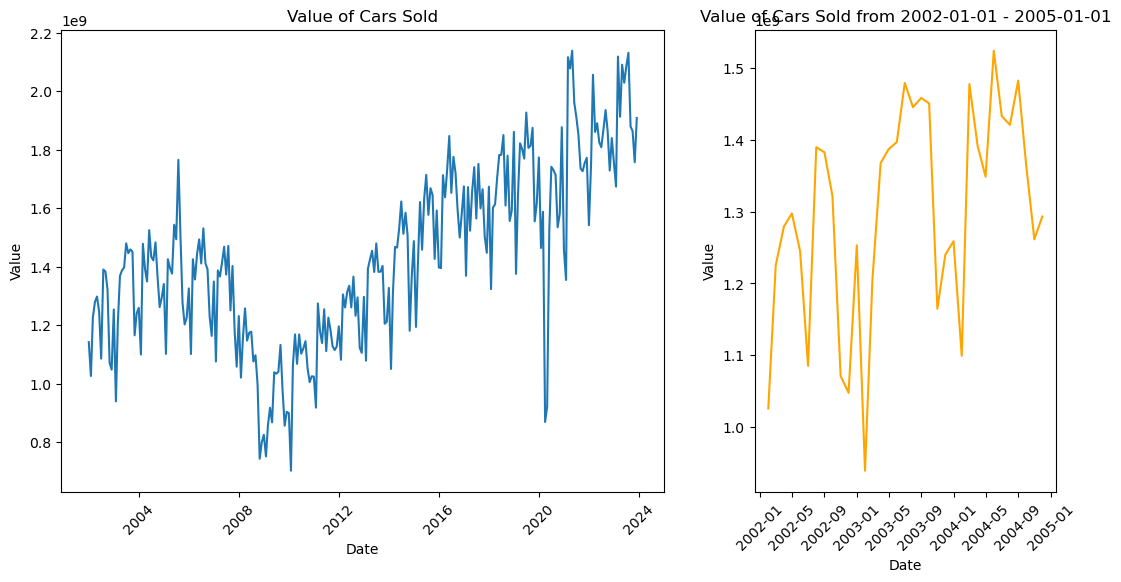

In [71]:
time_series_seasonal_analysis(value_cars_sold,
                              'total_value_cars_sold','Value of Cars Sold','2002-01-01','2005-01-01')

Observation Left: